# Imports

## Grant access to your google drive (if using Google Collab), import python packages and set paths

### Tests if mounting google drive is possible to determine if the code is run on google collab (GOOGLE=TRUE)

In [0]:
import numpy as np
import pandas as pd
import re
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    GOOGLE = True
    baseFolder = '/content/drive/My Drive/DeeProtein2/'
except:
    GOOGLE = False
    baseFolder = '/home/kristian/DeeProtein2/'
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
if GOOGLE:
    !pip install swifter
import swifter #parallelizes pandas dataframes (not required, just remove from code)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
     |████████████████████████████████| 61kB 4.0MB/s 
  Created wheel for swifter: filename=swifter-0.295-cp36-none-any.whl size=6641 sha256=70ce8701d5e921df9221b04f2b6057c929c0b6da758e374869fec5bb3d29822d
  Stored in directory: /root/.cache/pip/wheels/7a/45/c9/3f3efdf849089406d6601314016dd99f8b15480944e3bf8dad
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4039 sha256=bdc03fbea65d966bfd951174baa893433e684a05bd8a44633ecf11bfa39b864e


In [0]:
datasetFolder = baseFolder + 'CleaningDataset/'
testSetFolder = baseFolder + 'Datasets/'
godagFile = datasetFolder + 'go-basic.obo'
if not os.path.exists(testSetFolder):
    if GOOGLE:
        drive.mount('/content/drive/', force_remount=True)
    os.mkdir(testSetFolder)

Mounted at /content/drive/


In [0]:
#minimum numbers of representatives per GO term in final dataset
critThresh = 100

In [0]:
df = pd.read_csv(datasetFolder+'filteredSwissProt_LengthSeq50TO650_noDupl_reduced_OnlCnc.csv', usecols=['seq','seqNum','C_GOAll','F_GOAll','P_GOAll'])

In [0]:
df.keys()

Index(['seq', 'seqNum', 'C_GOAll', 'F_GOAll', 'P_GOAll'], dtype='object')

In [0]:
df.head()

,seq,seqNum,C_GOAll,F_GOAll,P_GOAll
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...,"[11, 1, 5, 16, 1, 4, 3, 18, 10, 9, 4, 20, 3, 1...",NaN,NaN,"['GO:0065007', 'GO:0050789', 'GO:0008150', 'GO..."
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...,"[11, 16, 8, 8, 6, 1, 17, 15, 10, 14, 12, 3, 9,...","['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN
2,MNAKYDTDQGVGRMLFLGTIGLAVVVGGLMAYGYYYDGKTPSSGTS...,"[11, 12, 1, 9, 20, 3, 17, 3, 14, 6, 18, 6, 15,...","['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN
3,MKMDTDCRHWIVLASVPVLTVLAFKGEGALALAGLLVMAAVAMYRD...,"[11, 9, 11, 3, 17, 3, 2, 15, 7, 19, 8, 18, 10,...","['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN
4,MTSVKTIAMLAMLVIVAALIYMGYRTFTSMQSKLNELESRVNAPQL...,"[11, 17, 16, 18, 9, 17, 8, 1, 11, 10, 1, 11, 1...","['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN


# Determine labels for training

## Visualizing labels

In [0]:
def split(x):
    if x is not np.nan:
        x = re.findall('(GO:[0-9]{7})',x)
    return x
# df['C_GOAll'] = df['C_GOAll'].swifter.apply(split)
# df['F_GOAll'] = df['F_GOAll'].swifter.apply(split)
# df['P_GOAll'] = df['P_GOAll'].swifter.apply(split)

df['C_GOAll'] = df['C_GOAll'].apply(split)
df['F_GOAll'] = df['F_GOAll'].apply(split)
df['P_GOAll'] = df['P_GOAll'].apply(split)

In [0]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [0]:
cgon = (df['C_GOAll'].dropna().apply(lambda x: np.array(x,dtype=str))).values
fgon = (df['F_GOAll'].dropna().apply(lambda x: np.array(x,dtype=str))).values
pgon = (df['P_GOAll'].dropna().apply(lambda x: np.array(x,dtype=str))).values
pgon = flatten(pgon)
fgon = flatten(fgon)
cgon = flatten(cgon)

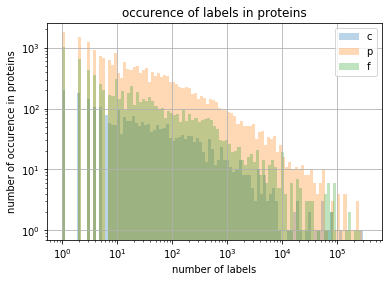

In [0]:
#occurences of labels in dataset proteins split by C,P,F terms
plt.figure()
ara = cgon
values = pd.DataFrame(ara)[0].value_counts()
df_C = values.rename_axis('unique_values').reset_index(name='counts')
bins = 10**np.linspace(np.log10(np.min(values)),np.log10(np.max(values)),100)
pd.DataFrame(ara)[0].value_counts().hist(bins=bins,log=1,alpha=0.3,label='c')

ara = pgon
values = pd.DataFrame(ara)[0].value_counts()
df_P = values.rename_axis('unique_values').reset_index(name='counts')
bins = 10**np.linspace(np.log10(np.min(values)),np.log10(np.max(values)),100)
pd.DataFrame(ara)[0].value_counts().hist(bins=bins,log=1,alpha=0.3,label='p')

ara = fgon
values = pd.DataFrame(ara)[0].value_counts()
df_F = values.rename_axis('unique_values').reset_index(name='counts')
bins = 10**np.linspace(np.log10(np.min(values)),np.log10(np.max(values)),100)
pd.DataFrame(ara)[0].value_counts().hist(bins=bins,log=1,alpha=0.3,label='f')
plt.title('occurence of labels in proteins')
plt.xlabel('number of labels')
plt.ylabel('number of occurence in proteins')
plt.xscale('log')
plt.legend()

In [0]:
#number of sequences with more than cutN representatives (with replacement)
cutN = 100
print(df_C.loc[df_C['counts']>cutN].shape,df_C.shape)
print(df_P.loc[df_P['counts']>cutN].shape,df_P.shape)
print(df_F.loc[df_F['counts']>cutN].shape,df_F.shape)
print('number of C terms: %g, P terms: %g, F terms: %g, total number of terms %g' %(df_C.shape[0], df_P.shape[0], df_F.shape[0], df_C.shape[0]+df_P.shape[0]+df_F.shape[0]))

(619, 2) (2611, 2)
(4058, 2) (19980, 2)
(1449, 2) (7348, 2)
number of C terms: 2611, P terms: 19980, F terms: 7348, total number of terms 29939


## Combine all terms in column 'GoAll'


In [0]:
def summarizeGoTerms(*terms):
    return flatten([x for x in terms if x is not np.nan])
df['GoAll'] = df.apply(lambda row: summarizeGoTerms(row['C_GOAll'],row['F_GOAll'],row['P_GOAll']), axis=1)

In [0]:
df.head()

,seq,seqNum,C_GOAll,F_GOAll,P_GOAll,GoAll
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...,"[11, 1, 5, 16, 1, 4, 3, 18, 10, 9, 4, 20, 3, 1...",NaN,NaN,"[GO:0065007, GO:0050789, GO:0008150, GO:004390...","[GO:0065007, GO:0050789, GO:0008150, GO:004390..."
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...,"[11, 16, 8, 8, 6, 1, 17, 15, 10, 14, 12, 3, 9,...","[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364..."
2,MNAKYDTDQGVGRMLFLGTIGLAVVVGGLMAYGYYYDGKTPSSGTS...,"[11, 12, 1, 9, 20, 3, 17, 3, 14, 6, 18, 6, 15,...","[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364..."
3,MKMDTDCRHWIVLASVPVLTVLAFKGEGALALAGLLVMAAVAMYRD...,"[11, 9, 11, 3, 17, 3, 2, 15, 7, 19, 8, 18, 10,...","[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364..."
4,MTSVKTIAMLAMLVIVAALIYMGYRTFTSMQSKLNELESRVNAPQL...,"[11, 17, 16, 18, 9, 17, 8, 1, 11, 10, 1, 11, 1...","[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364..."


In [0]:
goall=flatten(df['GoAll'].values)

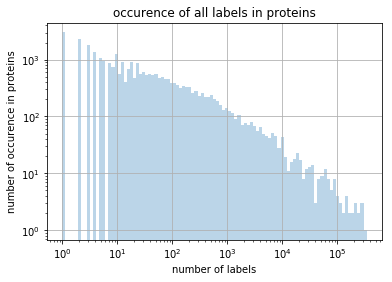

In [0]:
#occurences of labels in dataset proteins all terms together
plt.figure()
ara = goall
values = pd.DataFrame(ara)[0].value_counts()
df_GoAll = values.rename_axis('goTerm').reset_index(name='counts')
bins = 10**np.linspace(np.log10(np.min(values)),np.log10(np.max(values)),100)
pd.DataFrame(ara)[0].value_counts().hist(bins=bins,log=1,alpha=0.3)
plt.title('occurence of all labels in proteins')
plt.xlabel('number of labels')
plt.ylabel('number of occurence in proteins')
plt.xscale('log')

## Find all terms which appear  more than 100 times (critThresh) in total

In [0]:
#first determine all terms that are present at least 100 times (critThresh) 
goTermsDF = df_GoAll.loc[df_GoAll['counts']>=critThresh][::-1]
goTermsList = goTermsDF['goTerm'].values
np.save(datasetFolder+'allTerms_More100.npy', goTermsList)

In [0]:
print('find total of %g with at least 100 (critThres) present' %len(goTermsList))

find total of 6150 with at least 100 (critThres) present


In [0]:
#combine terms to one string where terms seperated by dash
df['GoAllStr'] = df['GoAll'].apply(lambda x: '-'.join(x))

In [0]:
df.head()

,seq,seqNum,C_GOAll,F_GOAll,P_GOAll,GoAll,GoAllStr
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...,"[11, 1, 5, 16, 1, 4, 3, 18, 10, 9, 4, 20, 3, 1...",NaN,NaN,"[GO:0065007, GO:0050789, GO:0008150, GO:004390...","[GO:0065007, GO:0050789, GO:0008150, GO:004390...",GO:0065007-GO:0050789-GO:0008150-GO:0043903-GO...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...,"[11, 16, 8, 8, 6, 1, 17, 15, 10, 14, 12, 3, 9,...","[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",GO:0016021-GO:0110165-GO:0031224-GO:0033643-GO...
2,MNAKYDTDQGVGRMLFLGTIGLAVVVGGLMAYGYYYDGKTPSSGTS...,"[11, 12, 1, 9, 20, 3, 17, 3, 14, 6, 18, 6, 15,...","[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",GO:0016021-GO:0110165-GO:0031224-GO:0033643-GO...
3,MKMDTDCRHWIVLASVPVLTVLAFKGEGALALAGLLVMAAVAMYRD...,"[11, 9, 11, 3, 17, 3, 2, 15, 7, 19, 8, 18, 10,...","[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",GO:0016021-GO:0110165-GO:0031224-GO:0033643-GO...
4,MTSVKTIAMLAMLVIVAALIYMGYRTFTSMQSKLNELESRVNAPQL...,"[11, 17, 16, 18, 9, 17, 8, 1, 11, 10, 1, 11, 1...","[GO:0016021, GO:0110165, GO:0031224, GO:003364...",NaN,NaN,"[GO:0016021, GO:0110165, GO:0031224, GO:003364...",GO:0016021-GO:0110165-GO:0031224-GO:0033643-GO...


In [0]:
df.to_csv(datasetFolder+'filteredSwissProt_LengthSeq50TO650_noDupl_reduced_OnlCnc_AlLab.csv')

In [0]:
df = pd.read_csv(datasetFolder+'filteredSwissProt_LengthSeq50TO650_noDupl_reduced_OnlCnc_AlLab.csv')#, sep=';')

In [0]:
df.head()

,Unnamed: 0,seq,seqNum,C_GOAll,F_GOAll,P_GOAll,GoAll,GoAllStr
0,0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...,"[11, 1, 5, 16, 1, 4, 3, 18, 10, 9, 4, 20, 3, 1...",NaN,NaN,"['GO:0065007', 'GO:0050789', 'GO:0008150', 'GO...","['GO:0065007', 'GO:0050789', 'GO:0008150', 'GO...",GO:0065007-GO:0050789-GO:0008150-GO:0043903-GO...
1,1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...,"[11, 16, 8, 8, 6, 1, 17, 15, 10, 14, 12, 3, 9,...","['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN,"['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",GO:0016021-GO:0110165-GO:0031224-GO:0033643-GO...
2,2,MNAKYDTDQGVGRMLFLGTIGLAVVVGGLMAYGYYYDGKTPSSGTS...,"[11, 12, 1, 9, 20, 3, 17, 3, 14, 6, 18, 6, 15,...","['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN,"['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",GO:0016021-GO:0110165-GO:0031224-GO:0033643-GO...
3,3,MKMDTDCRHWIVLASVPVLTVLAFKGEGALALAGLLVMAAVAMYRD...,"[11, 9, 11, 3, 17, 3, 2, 15, 7, 19, 8, 18, 10,...","['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN,"['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",GO:0016021-GO:0110165-GO:0031224-GO:0033643-GO...
4,4,MTSVKTIAMLAMLVIVAALIYMGYRTFTSMQSKLNELESRVNAPQL...,"[11, 17, 16, 18, 9, 17, 8, 1, 11, 10, 1, 11, 1...","['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",NaN,NaN,"['GO:0016021', 'GO:0110165', 'GO:0031224', 'GO...",GO:0016021-GO:0110165-GO:0031224-GO:0033643-GO...


In [0]:
goTermsList = np.load(datasetFolder+'allTerms_More100.npy', allow_pickle=True)

In [0]:
#go through terms with at least 100 terms initially; take out 100 terms if still present as representatives of this term; index every found term with 'TermNum' 
#takes a while to execute
df['TermNum'] = np.nan
df.reset_index(drop=True, inplace=True)
df_new = pd.DataFrame(columns = df.keys())
usedTerms = []
unusedTerms = []
termNum = 0
termUnused = 0
for term in goTermsList:
    indices = df.index[df['GoAllStr'].str.contains(term)].values[:critThresh]
    numElementsFound = np.shape(indices)[0]
    if numElementsFound >= critThresh:
        usedTerms.append(term)
        df['TermNum'].iloc[indices] = termNum
        df_new = df_new.append(df.iloc[indices], ignore_index=True)
        df.drop(index=indices, inplace=True)
        df.reset_index(drop=True, inplace=True)
        termNum += 1
        if termNum%50==0:
            print('%g terms found with available sequences of at least %g, found %g elements for current term %s' %(termNum,critThresh,numElementsFound,term))
    else:
        unusedTerms.append(term)
        termUnused += 1
        if termUnused%50==0:
            print('found term %s only %g times, total number unused %g' %(term,numElementsFound,termUnused))
df_new.to_csv(datasetFolder+'filteredSwissProt_LengthSeq50TO650_noDupl_reduced_OnlCnc_AlLab_new.csv')        
df.to_csv(datasetFolder+'filteredSwissProt_LengthSeq50TO650_noDupl_reduced_OnlCnc_AlLab_OLD.csv')
np.save(datasetFolder+'unusedTerms.npy', unusedTerms)
np.save(datasetFolder+'usedTerms.npy', usedTerms)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


found term GO:0006268 only 93 times, total number unused 50
50 terms found with available sequences of at least 100, found 100 elements for current term GO:0008880
found term GO:0007080 only 90 times, total number unused 100
100 terms found with available sequences of at least 100, found 100 elements for current term GO:0042365
found term GO:0030149 only 95 times, total number unused 150
found term GO:0097730 only 97 times, total number unused 200
150 terms found with available sequences of at least 100, found 100 elements for current term GO:0009629
found term GO:0033120 only 97 times, total number unused 250
found term GO:0031295 only 77 times, total number unused 300
200 terms found with available sequences of at least 100, found 100 elements for current term GO:0032806
found term GO:0019886 only 66 times, total number unused 350
found term GO:0051972 only 72 times, total number unused 400
250 terms found with available sequences of at least 100, found 100 elements for current term 

In [0]:
df_new.head()

In [0]:
#assign index to every term in list of used terms
def indexToTerms(l, usedTerms):
    return [index for index,term in enumerate(usedTerms) if term in l]
df['IndexUsed'] = df['GoAll'].swifter.apply(lambda x: indexToTerms(x, usedTerms))    
df_new['IndexUsed'] = df_new['GoAll'].swifter.apply(lambda x: indexToTerms(x, usedTerms))

In [0]:
len(df['IndexUsed'].values[0])

In [0]:
df['FinalLabelCounts'] = df['IndexUsed'].swifter.apply(lambda x: len(x))
df_new['FinalLabelCounts'] = df_new['IndexUsed'].swifter.apply(lambda x: len(x))

In [0]:
df_final = df_new.append(df)

In [0]:
df_final.to_csv(datasetFolder+'filteredSwissProt_LengthSeq50TO650_noDupl_reduced_OnlCnc_SeqProb.csv')#, columns=['seq','C_GOAll','F_GOAll','P_GOAll'])

In [0]:
df_final.head()

### df now includes remaining sequences not chosen  as first 100 proteins representing the respective label; df_new includes chosen proteins 

In [0]:
df.shape, df_new.shape, df.shape[0]+df_new.shape[0]

In [0]:
df_new.head()

,Unnamed: 0,seq,seqNum,C_GOAll,F_GOAll,P_GOAll,GoAll,GoAllStr,TermNum,IndexUsed,FinalLabelCounts
0,2974,MAAEEEEVDSADTGERSGWLTGWLPTWCPTSISHLKEAEEKMLKCV...,"[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60
1,2975,MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,"[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0044093', 'GO:0006654', 'GO:0050790', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60
2,2976,MAAEEEEMDSTDACERSGWLTGWLPTWCPTSTSHLKEAEEKILKCV...,"[11, 1, 1, 4, 4, 4, 4, 11, 3, 16, 17, 3, 1, 2,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0030154', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60
3,2977,MAAEEEEVDSADTGERSGWLTGWLPTWCPTSTSHLKEAEEKMLKCV...,"[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0071617', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2413, ...",56
4,2978,MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,"[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60


In [0]:
np.max([x for l in df_new['IndexUsed'].values for x in l])

2880

# Do training-validate split and save as numpy arrays

In [0]:
df = pd.read_csv(datasetFolder+'filteredSwissProt_LengthSeq50TO650_noDupl_reduced_OnlCnc_SeqProb.csv')

In [0]:
usedTerms = np.load(datasetFolder+'usedTerms.npy')

In [0]:
df.reset_index(drop=True, inplace=True)

In [0]:
df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [0]:
df.drop(labels='Unnamed: 0.1', axis=1, inplace=True)

In [0]:
df.head()

,seq,seqNum,C_GOAll,F_GOAll,P_GOAll,GoAll,GoAllStr,TermNum,IndexUsed,FinalLabelCounts
0,MAAEEEEVDSADTGERSGWLTGWLPTWCPTSISHLKEAEEKMLKCV...,"[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60
1,MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,"[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0044093', 'GO:0006654', 'GO:0050790', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60
2,MAAEEEEMDSTDACERSGWLTGWLPTWCPTSTSHLKEAEEKILKCV...,"[11, 1, 1, 4, 4, 4, 4, 11, 3, 16, 17, 3, 1, 2,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0030154', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60
3,MAAEEEEVDSADTGERSGWLTGWLPTWCPTSTSHLKEAEEKMLKCV...,"[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0071617', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2413, ...",56
4,MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,"[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60


In [0]:
validate_percentage = 0.3
NumberValidate = int(critThresh * 0.3)
print('want to use at least fraction of %.2f for validation which corresponds to at least %i labels per term'%(validate_percentage,int(validate_percentage*100)))

want to use at least fraction of 0.30 for validation which corresponds to at least 30 labels per term


In [0]:
#randomly pick sequences for validation set from representations and assign 0 to column'TestSet'
df['TestSet'] = 1
np.random.seed(42)
for i in range(np.size(usedTerms)):
    if i%500==0:
        print('at index %i' %i)
        print(df['TestSet'].value_counts())
    indices = (df.loc[df['TermNum']==i]).index
    rndIndx = np.random.choice(np.arange(np.size(indices)), size=NumberValidate, replace=False)
    df['TestSet'].iloc[indices[rndIndx]] = 0

at index 0
1    386980
Name: TestSet, dtype: int64
at index 500
1    371980
0     15000
Name: TestSet, dtype: int64
at index 1000
1    356980
0     30000
Name: TestSet, dtype: int64
at index 1500
1    341980
0     45000
Name: TestSet, dtype: int64
at index 2000
1    326980
0     60000
Name: TestSet, dtype: int64
at index 2500
1    311980
0     75000
Name: TestSet, dtype: int64


In [0]:
df['TestSet'].value_counts()

1    300550
0     86430
Name: TestSet, dtype: int64

In [0]:
#assign 2 to column TestSet for sequences that are not representing any term
def AdditionalTestSet(x):
    print(x)
    if x is np.nan:
        return 2
    else:
        return x
df['TestSet'].loc[pd.isna(df['TermNum'])]=2

In [0]:
pd.isna(df['TermNum']).value_counts()

False    288100
True      98880
Name: TermNum, dtype: int64

In [0]:
df['TestSet'].value_counts()

1    201670
2     98880
0     86430
Name: TestSet, dtype: int64

In [0]:
df.head()

,seq,seqNum,C_GOAll,F_GOAll,P_GOAll,GoAll,GoAllStr,TermNum,IndexUsed,FinalLabelCounts,TestSet
0,MAAEEEEVDSADTGERSGWLTGWLPTWCPTSISHLKEAEEKMLKCV...,"[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60,0
1,MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,"[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0044093', 'GO:0006654', 'GO:0050790', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60,1
2,MAAEEEEMDSTDACERSGWLTGWLPTWCPTSTSHLKEAEEKILKCV...,"[11, 1, 1, 4, 4, 4, 4, 11, 3, 16, 17, 3, 1, 2,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0030154', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60,1
3,MAAEEEEVDSADTGERSGWLTGWLPTWCPTSTSHLKEAEEKMLKCV...,"[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0071617', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2413, ...",56,1
4,MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,"[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60,0


In [0]:
def SplitIntegers(x):
    return np.array([int(x) for x in re.findall('[/ []([0-9]+)',x)])
df['IndexUsedInt'] = df['IndexUsed'].swifter.apply(SplitIntegers) 
df['seqNumInt'] = df['seqNum'].swifter.apply(SplitIntegers)

In [0]:
df.head()

,seq,seqNum,C_GOAll,F_GOAll,P_GOAll,GoAll,GoAllStr,TermNum,IndexUsed,FinalLabelCounts,TestSet,IndexUsedInt,seqNumInt
0,MAAEEEEVDSADTGERSGWLTGWLPTWCPTSISHLKEAEEKMLKCV...,"[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60,0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,..."
1,MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,"[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0044093', 'GO:0006654', 'GO:0050790', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60,1,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,..."
2,MAAEEEEMDSTDACERSGWLTGWLPTWCPTSTSHLKEAEEKILKCV...,"[11, 1, 1, 4, 4, 4, 4, 11, 3, 16, 17, 3, 1, 2,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0030154', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60,1,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 1, 1, 4, 4, 4, 4, 11, 3, 16, 17, 3, 1, 2,..."
3,MAAEEEEVDSADTGERSGWLTGWLPTWCPTSTSHLKEAEEKMLKCV...,"[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0071617', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2413, ...",56,1,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2413, ...","[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,..."
4,MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,"[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...","['GO:0042171', 'GO:0003841', 'GO:0016787', 'GO...","['GO:0043436', 'GO:0065007', 'GO:0044093', 'GO...","['GO:0005829', 'GO:0044424', 'GO:0005811', 'GO...",GO:0005829-GO:0044424-GO:0005811-GO:0005575-GO...,0.0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...",60,0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,..."


In [0]:
#save dataset where test set indicated
df[['IndexUsed', 'seqNum', 'seq', 'TestSet']].to_csv(datasetFolder+'filteredSwissProt_LengthSeq50TO650_noDupl_OnlCnc_SeqProb_TesSet_reduced.csv')

In [0]:
df = pd.read_csv(datasetFolder+'filteredSwissProt_LengthSeq50TO650_noDupl_OnlCnc_SeqProb_TesSet_reduced.csv')

In [0]:
df.head()

,Unnamed: 0,IndexUsed,seqNum,seq,TestSet
0,0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...",MAAEEEEVDSADTGERSGWLTGWLPTWCPTSISHLKEAEEKMLKCV...,0
1,1,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...",MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,1
2,2,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 1, 1, 4, 4, 4, 4, 11, 3, 16, 17, 3, 1, 2,...",MAAEEEEMDSTDACERSGWLTGWLPTWCPTSTSHLKEAEEKILKCV...,1
3,3,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2413, ...","[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...",MAAEEEEVDSADTGERSGWLTGWLPTWCPTSTSHLKEAEEKMLKCV...,1
4,4,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...",MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,0


In [0]:
df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [0]:
# pandas saves lists as string, have to convert str of all terms to list of terms
def SplitIntegers(x):
    return [int(x) for x in re.findall('[/ []([0-9]+)',x)]

df['IndexUsed'] = df['IndexUsed'].swifter.apply(SplitIntegers)
df['seqNum'] = df['seqNum'].swifter.apply(SplitIntegers)

/home/kristian/miniconda3/envs/bioC/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [0]:
df.head()

,IndexUsed,seqNum,seq,TestSet
0,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...",MAAEEEEVDSADTGERSGWLTGWLPTWCPTSISHLKEAEEKMLKCV...,0
1,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...",MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,1
2,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 1, 1, 4, 4, 4, 4, 11, 3, 16, 17, 3, 1, 2,...",MAAEEEEMDSTDACERSGWLTGWLPTWCPTSTSHLKEAEEKILKCV...,1
3,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2413, ...","[11, 1, 1, 4, 4, 4, 4, 18, 3, 16, 1, 3, 17, 6,...",MAAEEEEVDSADTGERSGWLTGWLPTWCPTSTSHLKEAEEKMLKCV...,1
4,"[0, 1129, 1810, 1923, 1956, 2170, 2214, 2326, ...","[11, 9, 1, 11, 1, 1, 4, 4, 4, 18, 3, 16, 1, 3,...",MKAMAAEEEVDSADAGGGSGWLTGWLPTWCPTSTSHLKEAEEKMLK...,0


In [0]:
#only include sets with make up critThreshold sample
def convertListOfArraysToInt32(ARRAY, dtype=np.int32):
    #convert integers in arrays to correcet dtype: int16 for encoded sequence and int16 for used terms
    return np.array([np.array(x, dtype=dtype) for x in ARRAY])
np.save(testSetFolder+'TestSetX',convertListOfArraysToInt32(df['seqNum'].loc[df['TestSet']==1].values, np.int16))
np.save(testSetFolder+'TestSetY',convertListOfArraysToInt32(df['IndexUsed'].loc[df['TestSet']==1].values))
#include validation set set by validation percentage of critThreshold sequences
np.save(testSetFolder+'ValidSetX',convertListOfArraysToInt32(df['seqNum'].loc[df['TestSet']==0].values, np.int16))
np.save(testSetFolder+'ValidSetY',convertListOfArraysToInt32(df['IndexUsed'].loc[df['TestSet']==0].values))
#include all remaining sequences that are not part of validation set
np.save(testSetFolder+'TotalTestSetX',convertListOfArraysToInt32(df['seqNum'].loc[df['TestSet']!=0].values, np.int16))
np.save(testSetFolder+'TotalTestSetY',convertListOfArraysToInt32(df['IndexUsed'].loc[df['TestSet']!=0].values))

NameError: name 'np' is not defined